In [202]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from pybt.tools.particles import *
import numpy as np
import pickle

In [203]:
T = 23.08 # GeV kinetic energy / init = 23.08
# T = 4.54 # GeV kinetic energy ion equivalent of 750 MeV/u
E0 = 0.938 # GeV/c^2 proton rest mass
E = T + E0 # total energy
gamma = E / E0 # gamma
beta = np.sqrt(1-gamma**(-2))
p = E*beta # GeV/c beam momentum

print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p,3)} GeV/c")

gamma = 25.606
beta = 0.999
p = 24.0 GeV/c


In [204]:
air_start_pos = 40
air_stop_pos = 60
steps = 0.25 # meters
inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

### Create the initial sequence and run MAD-X

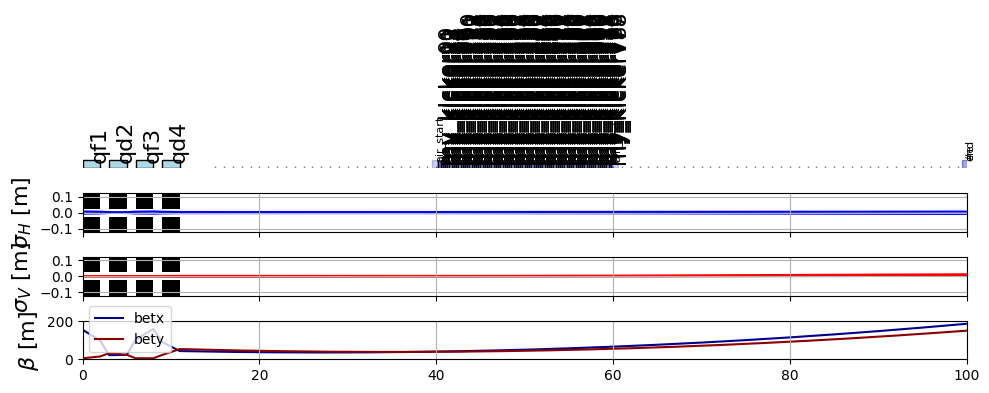

In [205]:
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)


L=steps
p_MeV = p*1000 # Beam total energy in MeV
q = 1
P = 1.01325 # Standard air pressure at sea level in Bar
P_Torr = P*750.062 # Standard air pressure at sea level in Torr
L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
L_rad = L_rad0/(P_Torr/760)

theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

# New theta_rms version from PDG
# https://pdg.lbl.gov/2017/AtomicNuclearProperties/HTML/air_dry_1_atm.html
# L_rad = 36.6
# theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)*(1+0.038*np.log(L/L_rad))

madx.input('''

QF : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
QD : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
''')

madx.input("MY_KICKER: HKICKER, L = 0;")
madx.input("MY_KICKERV: VKICKER, L = 0;")

for i in range(len(inner_marker_array)):
    madx.input(f"MY_KICKER{i} : MY_KICKER, KICK := kick{i};")
    madx.input(f"kick{i} = {np.random.normal(0, theta_rms)};")
    madx.input(f"MY_KICKERV{i} : MY_KICKERV, KICK := kickV{i};")
    madx.input(f"kickV{i} = {np.random.normal(0, theta_rms)};")

madx.input('''
AIR_START : MARKER;
AIR_END : MARKER;
END: MARKER;

QF1 : QF, K1 := kQF1;
QD2 : QD, K1 := kQD2;
QF3 : QF, K1 := kQF3;
QD4 : QD, K1 := kQD4;

kQF1 = 0.32730047;
kQD2 = -0.36102915;
kQF3 = 0.32789126;
kQD4 = -0.1991137;

simple_seq: SEQUENCE, refer = exit, l = 100;
QF1 : QF1, AT=2;
QD2 : QD2, AT=5;
QF3 : QF3, AT=8;
QD4 : QD4, AT=11;
''')

# Add the Air region
madx.input(f"AIR_START : AIR_START, AT={air_start_pos};")
for i, pos in enumerate(inner_marker_array):
    madx.input(f"MY_KICKER{i}: MY_KICKER{i}, AT={pos};")
    madx.input(f"MY_KICKERV{i}: MY_KICKERV{i}, AT={pos};")

madx.input(f'''    
AIR_END : AIR_END, AT={air_stop_pos};
END : END, AT=100;
ENDSEQUENCE;
''')

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

madx.command.beam(particle='PROTON',pc=p,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26,KICK;')
madx.input("SEQEDIT, SEQUENCE = simple_seq;")
# Create a for loop for the inner markers:
marker_names = []
for i in range(len(inner_marker_array)):
    name = "INNER_MARKER"+str(i)
    marker_names.append(name)
for count, pos in enumerate(inner_marker_array):
    madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
madx.input("ENDEDIT;")



# Add marker at the end of the line to see the evolution of the beam with fine resolution
madx.input("SEQEDIT, SEQUENCE = simple_seq;")
for count, pos in enumerate(np.arange(15, 100, 1)):
    madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
madx.input("ENDEDIT;")

madx.use(sequence="simple_seq")
madx.input("SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE=simple_seq;")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
plot_graph(twiss, ex, sige, ey)

In [206]:
with open('tempfile', 'r') as f:
	lines = f.readlines()
	for ele in lines:
		print('{}'.format(ele))



  ++++++++++++++++++++++++++++++++++++++++++++

  +     MAD-X 5.09.00  (64 bit, Darwin)      +

  + Support: mad@cern.ch, http://cern.ch/mad +

  + Release   date: 2023.05.05               +

  + Execution date: 2023.09.19 17:09:22      +

  ++++++++++++++++++++++++++++++++++++++++++++

++++++ info: seqedit - number of elements installed:  79

++++++ info: seqedit - number of elements moved:      0

++++++ info: seqedit - number of elements removed:    0

++++++ info: seqedit - number of elements replaced:   0

++++++ info: seqedit - number of elements installed:  85

++++++ info: seqedit - number of elements moved:      0

++++++ info: seqedit - number of elements removed:    0

++++++ info: seqedit - number of elements replaced:   0



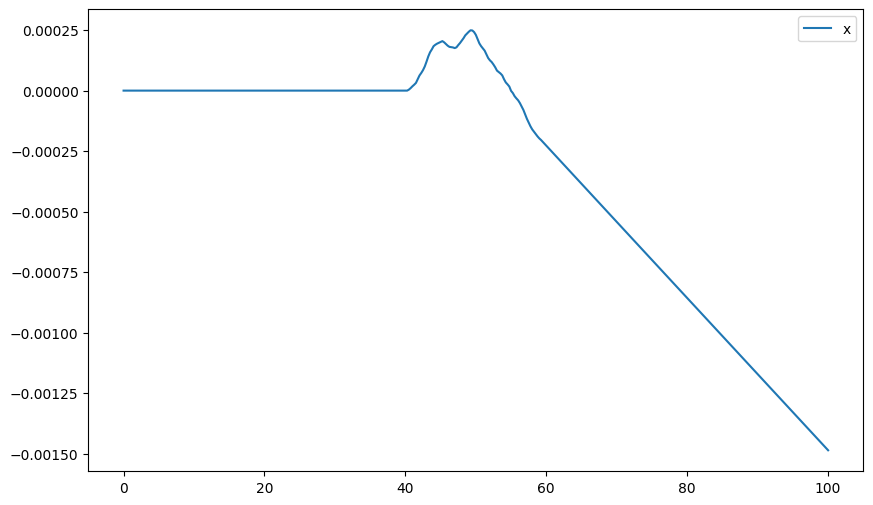

In [207]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(twiss.s, twiss.x, label="x")
ax.legend()

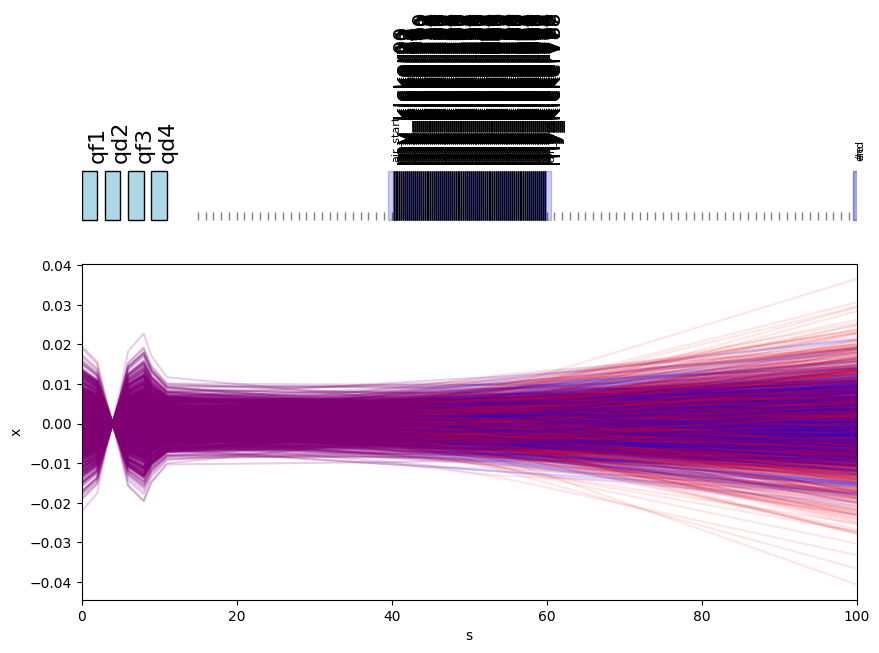

In [208]:
number_of_particles = 1000
n_sigma = 5

fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True, height_ratios=[1, 4])

twiss = madx.twiss(x = 0, px = 0, y = 0, py = 0, betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
draw_synoptic(ax[0], twiss)

s_list_air = []
s_list_vacuum = []
x_list_air = []
x_list_vacuum = []
particle_id_air = []
particle_id_vacuum = []

for p_id in range(number_of_particles):

    distH = beam_distrib_norm(alfx0, betx0, ex, 1, n_sigma)
    distV = beam_distrib_norm(alfy0, bety0, ey, 1, n_sigma)

    ## Not scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {0};")
        madx.input(f"kickV{i} = {0};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)
    ax[1].plot(twiss.s, twiss.x, color="blue", alpha=0.1)

    s_list_vacuum.append(list(twiss.s))
    x_list_vacuum.append(list(twiss.x))
    particle_id_vacuum.append(list([p_id]*len(twiss.s)))


    ## Scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {np.random.normal(0, theta_rms)};")
        madx.input(f"kickV{i} = {np.random.normal(0, theta_rms)};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)
    ax[1].plot(twiss.s, twiss.x, color="red", alpha=0.1)

    s_list_air.append(list(twiss.s))
    x_list_air.append(list(twiss.x))
    particle_id_air.append(list([p_id]*len(twiss.s)))

    ax[1].set_xlabel("s")
    ax[1].set_ylabel("x")

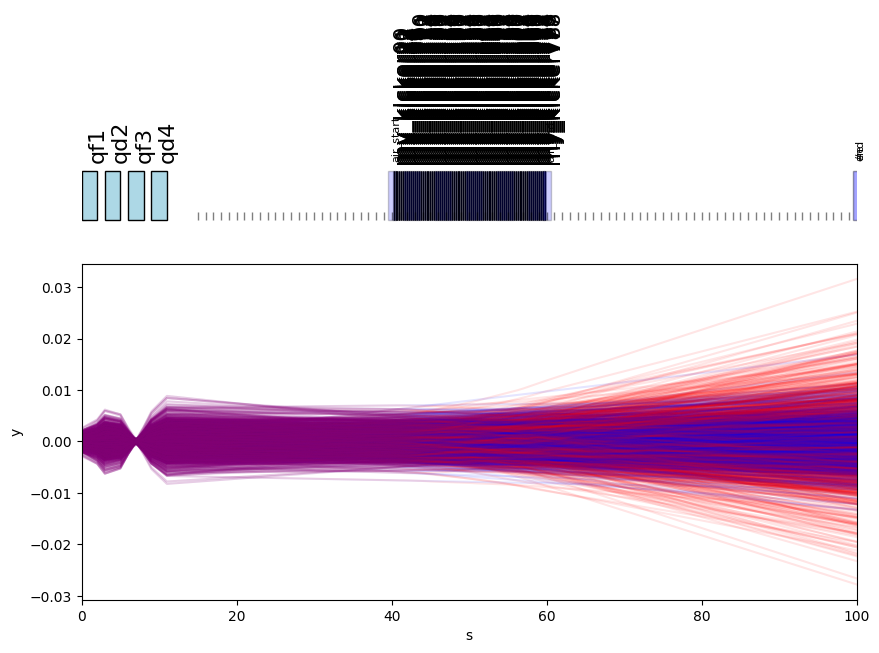

In [209]:
number_of_particles = 1000
n_sigma = 5

fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True, height_ratios=[1, 4])

twiss = madx.twiss(x = 0, px = 0, y = 0, py = 0, betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
draw_synoptic(ax[0], twiss)

y_list_air = []
y_list_vacuum = []

for i in range(number_of_particles):

    distH = beam_distrib_norm(alfx0, betx0, ex, 1, n_sigma)
    distV = beam_distrib_norm(alfy0, bety0, ey, 1, n_sigma)

    ## Not scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {0};")
        madx.input(f"kickV{i} = {0};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)
    ax[1].plot(twiss.s, twiss.y, color="blue", alpha=0.1)
    y_list_vacuum.append(list(twiss.y))

    ## Scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {np.random.normal(0, theta_rms)};")
        madx.input(f"kickV{i} = {np.random.normal(0, theta_rms)};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)
    ax[1].plot(twiss.s, twiss.y, color="red", alpha=0.1)
    y_list_air.append(list(twiss.y))


    ax[1].set_xlabel("s")
    ax[1].set_ylabel("y")

In [210]:
s_list_vacuum = np.array(s_list_vacuum).flatten()
s_list_air = np.array(s_list_air).flatten()
x_list_air = np.array(x_list_air).flatten()
x_list_vacuum = np.array(x_list_vacuum).flatten()
particle_id_air = np.array(particle_id_air).flatten()
particle_id_vacuum = np.array(particle_id_vacuum).flatten()
y_list_air = np.array(y_list_air).flatten()
y_list_vacuum = np.array(y_list_vacuum).flatten()


d = {'p_id': particle_id_air, 's': s_list_air, 'x': x_list_air, 'y': y_list_air}
df_air = pd.DataFrame(data=d)

d = {'p_id': particle_id_vacuum, 's': s_list_vacuum, 'x': x_list_vacuum, 'y': y_list_vacuum}
df_vacuum = pd.DataFrame(data=d)

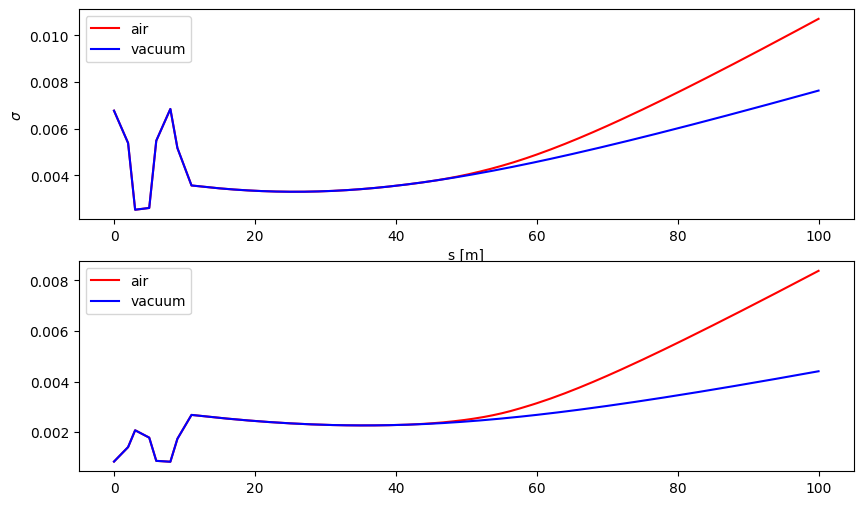

In [211]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

sigmaH_list = []
sigmaV_list = []
for i in np.sort(df_air.s.unique()):
    sigmaH = np.std(df_air.loc[df_air.s == i].x)
    sigmaH_list.append(sigmaH)
    sigmaV = np.std(df_air.loc[df_air.s == i].y)
    sigmaV_list.append(sigmaV)

ax[0].plot(np.sort(df_air.s.unique()), sigmaH_list, c="r", label="air")
ax[1].plot(np.sort(df_air.s.unique()), sigmaV_list, c="r", label="air")

d = {'s': np.sort(df_air.s.unique()), 'sigmaH': sigmaH_list, 'sigmaV': sigmaV_list}
df_monte_carlo_sigma_air = pd.DataFrame(data=d)

sigmaH_list = []
sigmaV_list = []
for i in np.sort(df_vacuum.s.unique()):
    sigmaH = np.std(df_vacuum.loc[df_vacuum.s == i].x)
    sigmaH_list.append(sigmaH)
    sigmaV = np.std(df_vacuum.loc[df_vacuum.s == i].y)
    sigmaV_list.append(sigmaV)

ax[0].plot(np.sort(df_vacuum.s.unique()), sigmaH_list, c="b", label="vacuum")
ax[1].plot(np.sort(df_vacuum.s.unique()), sigmaV_list, c="b", label="vacuum")


d = {'s': np.sort(df_vacuum.s.unique()), 'sigmaH': sigmaH_list, 'sigmaV': sigmaV_list}
df_monte_carlo_sigma_vacuum = pd.DataFrame(data=d)

ax[0].legend()
ax[0].set_xlabel("s [m]")
ax[0].set_ylabel(r"$\sigma$")

ax[1].legend()

## Export to pickle

In [212]:
with open('data/df_monte_carlo_sigma_air.pickle', 'wb') as handle:
    pickle.dump(df_monte_carlo_sigma_air, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/df_monte_carlo_sigma_vacuum.pickle', 'wb') as handle:
    pickle.dump(df_monte_carlo_sigma_vacuum, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/df_monte_carlo_vacuum.pickle', 'wb') as handle:
    pickle.dump(df_vacuum, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/df_monte_carlo_air.pickle', 'wb') as handle:
    pickle.dump(df_air, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
number_of_particles = 1000
n_sigma = 5

obs_pos_name = "end:1"

not_scattered_dict = {"x": [], "px": [], "y": [], "py": []}
scattered_dict = {"x": [], "px": [], "y": [], "py": []}

for i in range(number_of_particles):

    distH = beam_distrib_norm(alfx0, betx0, ex, 1, n_sigma)
    distV = beam_distrib_norm(alfy0, bety0, ey, 1, n_sigma)

    ## Not scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {0};")
        madx.input(f"kickV{i} = {0};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)


    ### Saving the data
    obs_pos = np.where(twiss.name == obs_pos_name)[0][0]
    obs_x = twiss.x[obs_pos]
    obs_px = twiss.px[obs_pos]
    obs_y = twiss.y[obs_pos]
    obs_py = twiss.py[obs_pos]
    not_scattered_dict["x"].append(obs_x)
    not_scattered_dict["px"].append(obs_px)
    not_scattered_dict["y"].append(obs_y)
    not_scattered_dict["py"].append(obs_py)


    ## Scattered
    for i in range(len(inner_marker_array)):
        madx.input(f"kick{i} = {np.random.normal(0, theta_rms)};")
        madx.input(f"kickV{i} = {np.random.normal(0, theta_rms)};")
    twiss = madx.twiss(x = distH[0][0], px = distH[0][1], y = distV[0][0], py = distV[0][1], betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0)

    ### Saving the data
    obs_pos = np.where(twiss.name == obs_pos_name)[0][0]
    obs_x = twiss.x[obs_pos]
    obs_px = twiss.px[obs_pos]
    obs_y = twiss.y[obs_pos]
    obs_py = twiss.py[obs_pos]
    scattered_dict["x"].append(obs_x)
    scattered_dict["px"].append(obs_px)
    scattered_dict["y"].append(obs_y)
    scattered_dict["py"].append(obs_py)


In [214]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), tight_layout=True)
ax[0].hist(scattered_dict["x"], alpha=0.5, label="scattered", bins=100)
ax[0].hist(not_scattered_dict["x"], alpha=0.5, label="not scattered", bins=100)
ax[0].set_xlabel("x")
ax[0].set_ylabel("counts")
ax[0].legend()
ax[0].set_xlim(-0.02, 0.02)

ax[1].hist(scattered_dict["y"], alpha=0.5, label="scattered", bins=100)
ax[1].hist(not_scattered_dict["y"], alpha=0.5, label="not scattered", bins=100)
ax[1].set_xlabel("y")
ax[1].set_ylabel("counts")
ax[1].legend()
ax[1].set_xlim(-0.02, 0.02)

(-0.02, 0.02)

In [215]:
# Compute the standard deviation for each distribution
std_scattered_x = np.std(scattered_dict["x"])
std_not_scattered_x = np.std(not_scattered_dict["x"])

std_scattered_y = np.std(scattered_dict["y"])
std_not_scattered_y = np.std(not_scattered_dict["y"])

# Compute the increase in sigma
increase_in_sigma_x = std_scattered_x - std_not_scattered_x
increase_in_sigma_y = std_scattered_y - std_not_scattered_y

# Compute the increase as a percentage
percentage_increase_x = (increase_in_sigma_x / std_not_scattered_x) * 100
percentage_increase_y = (increase_in_sigma_y / std_not_scattered_y) * 100

print(f"Increase in sigma for x: {round(percentage_increase_x,1)}%")
print(f"Increase in sigma for y: {round(percentage_increase_y,1)}%")

Increase in sigma for x: 40.8%
Increase in sigma for y: 98.2%


In [216]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].scatter(scattered_dict["x"], scattered_dict["px"], alpha=0.1, s=2, label="scattered")
ax[0].scatter(not_scattered_dict["x"], not_scattered_dict["px"], alpha=0.1, s=2, label="not scattered")
ax[0].set_xlabel("x")
ax[0].set_ylabel("px")
ax[0].legend()
ax[0].set_xlim(-0.05, 0.05)
ax[0].set_ylim(-0.0005, 0.0005)

ax[1].scatter(scattered_dict["y"], scattered_dict["py"], alpha=0.1, s=2, label="scattered")
ax[1].scatter(not_scattered_dict["y"], not_scattered_dict["py"], alpha=0.1, s=2, label="not scattered")
ax[1].set_xlabel("y")
ax[1].set_ylabel("py")
ax[1].legend()
ax[1].set_xlim(-0.05, 0.05)
ax[1].set_ylim(-0.0005, 0.0005)

fig.suptitle(f"Monte Carlo scattering at the end of the lattice\n {number_of_particles} particles, {round(theta_rms,3)} rms kick", fontsize=16)

Text(0.5, 0.98, 'Monte Carlo scattering at the end of the lattice\n 1000 particles, 0.0 rms kick')

## Pickle the data

In [217]:
d = {'x': not_scattered_dict["x"], 'xp': not_scattered_dict["px"], 'y': not_scattered_dict["y"], 'yp': not_scattered_dict["py"]}
df_monte_carlo_not_scattered = pd.DataFrame(data=d)

d = {'x': scattered_dict["x"], 'xp': scattered_dict["px"], 'y': scattered_dict["y"], 'yp': scattered_dict["py"]}
df_monte_carlo_scattered = pd.DataFrame(data=d)


In [218]:
import pickle
with open('data/df_monte_carlo_scattered.pickle', 'wb') as f:
    pickle.dump(df_monte_carlo_scattered, f)

with open('data/df_monte_carlo_not_scattered.pickle', 'wb') as f:
    pickle.dump(df_monte_carlo_not_scattered, f)

## Twiss parameters at the end of the lattice

In [219]:
from madxtools.particles import *

betx_bef, alfx_bef, gamma_bef, ex_bef = twiss_parameters_from_distribution(df_monte_carlo_not_scattered.x, df_monte_carlo_not_scattered.xp)
betx_aft, alfx_aft, gamma_aft, ex_aft = twiss_parameters_from_distribution(df_monte_carlo_scattered.x, df_monte_carlo_scattered.xp)


print(f"alfx monte carlo before = {round(alfx_bef,2)} after = {round(alfx_aft,2)}")
print(f"betx monte carlo before = {round(betx_bef,2)} after = {round(betx_aft,2)}")
print(f"ex monte carlo before = {round(ex_bef,9)} after = {round(ex_aft,9)}")


bety_bef, alfy_bef, gamma_bef, ey_bef = twiss_parameters_from_distribution(df_monte_carlo_not_scattered.y, df_monte_carlo_not_scattered.yp)
bety_aft, alfy_aft, gamma_aft, ey_aft = twiss_parameters_from_distribution(df_monte_carlo_scattered.y, df_monte_carlo_scattered.yp)

print(f"alfy monte carlo before = {round(alfy_bef,2)} after = {round(alfy_aft,2)}")
print(f"bety monte carlo before = {round(bety_bef,2)} after = {round(bety_aft,2)}")
print(f"ey monte carlo before = {round(ey_bef,9)} after = {round(ey_aft,9)}")

alfx monte carlo before = -2.1 after = -2.59
betx monte carlo before = 189.83 after = 167.12
ex monte carlo before = 2.82e-07 after = 6.34e-07
alfy monte carlo before = -1.67 after = -3.41
bety monte carlo before = 143.45 after = 195.53
ey monte carlo before = 1.35e-07 after = 3.88e-07
